# Bayes and SVM Models

In this the bayes and tf-idf models are generated. There will primarily be 4 models. 
- Bayes: on text
- Bayes: on text and keywords
- SVM: on text
- SVM: on text and keywords

In [1]:
import pandas as pd
import numpy as np
import re
import string
import spacy

# Only to clean once; use clean_dataset
# import clean

In [2]:
import nltk
from nltk.sentiment import vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon') ## this only needs to be run once

vader_model = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hasan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
%config Completer.use_jedi = False

In [6]:
# df = pd.read_csv('train.csv')

# # drop the instances where the keywords are missing
# df = df[df.keyword.notnull()]
# df = df[df.text.notnull()]

In [5]:
# Should we also use TextBlob and compare its performance with VADER!?
# df['compound'] = df['text'].apply(lambda x:vader_model.polarity_scores(x)['compound'])

In [5]:
# Do it only once!
# clean_data.clean(df, 'train', False)

In [3]:
train_df = pd.read_csv('train_full_clean.csv')
train_df = train_df[train_df['text'].notnull()]

In [4]:
train_df.head(100)

,keyword,text,target,hashtags
0,ablaz,wholesale market ablaze,1,NaN
1,ablaz,try bring heavy metal,0,metal rt
2,ablaz,africanbaze break news nigeria flag set ablaze...,1,africanbaze
3,ablaz,cry set ablaze,0,NaN
4,ablaz,plus look sky night ablaze,0,NaN
...,...,...,...,...
95,aftershock,man get oyster man get shell andrew carnegie,0,NaN
96,aftershock,need tonight play hybrid slayer eu hmu,0,NaN
97,airplan accid,expert france begin examine airplane debris fi...,1,news
98,airplan accid,strict liability context airplane accident pil...,1,NaN


# Helper Functions (tweaked)

In [6]:
from helpers import plot_roc, plot_results

def calculate_accuracy(XTest, yTest, model):
    X_test_final, _, y_test_final, _ = \
            train_test_split(XTest, yTest, test_size=0.5, shuffle=True)
    predict_test_final = model.predict(X_test_final)
    accuracy = metrics.accuracy_score(y_test_final, predict_test_final)
    return accuracy

def make_norm(X_test, y_test, clf):
    accuracies = []    
    for i in range(1000):
        accuracy = calculate_accuracy(X_test, y_test, clf)
        accuracies.append(round(accuracy, 3))
    return accuracies

# Models

In [7]:
# import for the models

import seaborn as sns
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import scipy.stats as ss

Splitting data in validation- and training set. We speak of validation and not test, becaues the test data is contained within a separate file and thus is not present within the current dataframe. 

We can refer to these for all four models that are present here:

In [8]:
# This cell can be an overarching train testsplit cell.

x_keyword = train_df['keyword']
x_text = train_df['text']
y = train_df['target']

x_train, x_test, y_train, y_test = train_test_split(x_text, y, test_size=0.2) # for what do we use the random state?

In [9]:
# Needed for stacking

keyword_vectorizer = CountVectorizer()
keyword_vectors = keyword_vectorizer.fit_transform(train_df['keyword'])

text_vectorizer = CountVectorizer()
text_vectors = text_vectorizer.fit_transform(train_df['text'])

# x_features_train is a combined representation containing both the keywords and the text vectors
x_features_train = sp.hstack([keyword_vectors, text_vectors], format='csr')

# y is decided above
x_train_stack, x_test_stack, y_train_stack, y_test_stack = train_test_split(x_features_train, y, test_size=0.2)

text_val_stack, text_val_test_stack, target_val_stack, target_val_test_stack = train_test_split(x_test_stack, y_test_stack, test_size=0.50)

In [10]:
# Needed for concatination

combine_texts = lambda x: x.keyword + " " + x.keyword + " " + x.keyword + " " + x.text
train_df['kt_combined'] = train_df.apply(combine_texts, axis=1)
train_df.head()

x_con = train_df['kt_combined']

vect_con = CountVectorizer()

# y is given above
x_train_con, x_test_con, y_train_con, y_test_con = train_test_split(x_con, y, test_size=0.2, random_state=40)

text_val_con, text_val_test_con, target_val_con, target_val_test_con = train_test_split(x_test_con, y_test_con, test_size=0.50)

vect_con.fit(x_train_con)

x_train_vect_con = vect_con.transform(x_train_con)
x_test_vect_con = vect_con.transform(x_test_con)
x_val_vec_con = vect_con.transform(text_val_test_con)


## SVM

In [11]:
# Support Vector Machines
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

### Pipeline usage for TFidf with SVM

Here we run make use of tf-idf in combination with the a svm.

Important to note is that this model only runs on one feature, i.e. the text.
Thereby the model does not include 'keywords' in its prediction. 

In [12]:
text_clf_svm = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', SVC(probability=True)),
])

# Feed the training data through the pipeline
text_clf_svm.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', SVC(probability=True))])

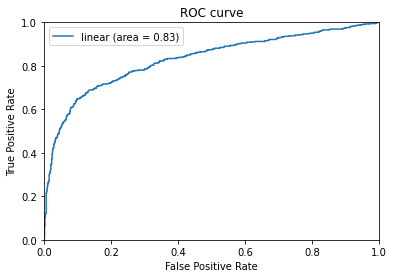

In [13]:
plot_roc(text_clf_svm, x_test, y_test)

In [14]:
accuracies = make_norm(x_test, y_test, text_clf_svm)

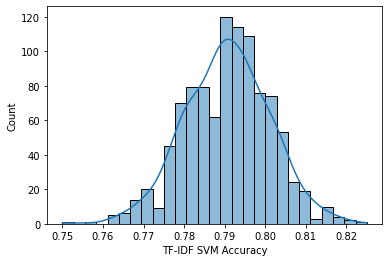

In [15]:
plot_results(accuracies, 'TF-IDF SVM Accuracy')

### SVM model: with both keywords and text as features

Here we run make use of tf-idf in combination with the a svm on two features.

Important to note is that this model only runs on two features, i.e. the keyword and text.

#### Stacking

In [16]:
# clf_svm_stack = LinearSVC() 
clf_svm_stack = SVC(probability=True) 

clf_svm_stack.fit(x_train_stack, y_train_stack)

SVC(probability=True)

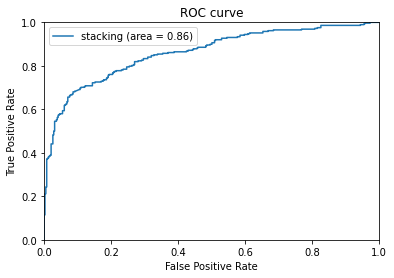

In [17]:
plot_roc(clf_svm_stack, text_val_test_stack, target_val_test_stack, 'stacking')

In [18]:
accuracies = make_norm(text_val_test_stack, target_val_test_stack, clf_svm_stack)

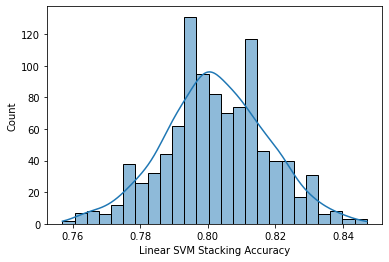

In [19]:
plot_results(accuracies, 'Linear SVM Stacking Accuracy')

#### Concatenation

In [20]:
# clf_svm_con = LinearSVC() 
clf_svm_con = SVC(probability=True) 

clf_svm_con.fit(x_train_vect_con, y_train_con)

SVC(probability=True)

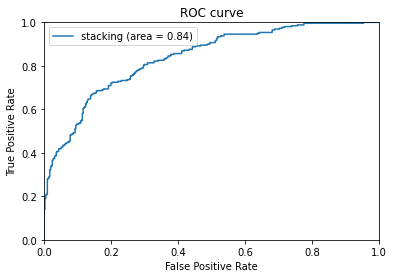

In [21]:
plot_roc(clf_svm_con, x_val_vec_con, target_val_test_con, 'concatenation')

In [22]:
accuracies = make_norm(x_val_vec_con, target_val_test_con, clf_svm_con)

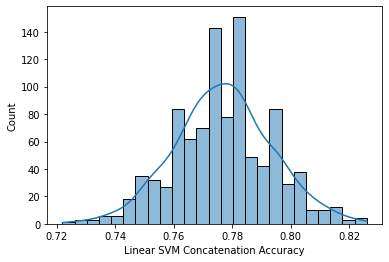

In [23]:
plot_results(accuracies, 'Linear SVM Concatenation Accuracy')

## Bayesain classifier

In [24]:
# Bayes
from sklearn.naive_bayes import MultinomialNB

### Pipeline usage for TFidf with Bayes

Here we run make use of tf-idf in combination with the a bayes.

Important to note is that this model only runs on one feature, i.e. the text.
Thereby the model does not include 'keywords' in its prediction. 

In [25]:
text_clf_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])
text_clf_nb.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

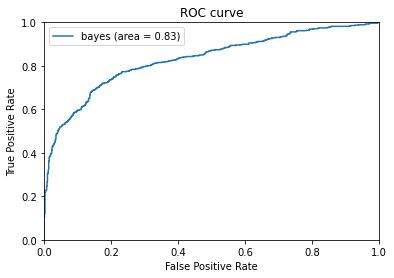

In [26]:
plot_roc(text_clf_nb, x_test, y_test, 'tdidf bayes')

In [27]:
accuracies = make_norm(x_test, y_test, text_clf_nb)

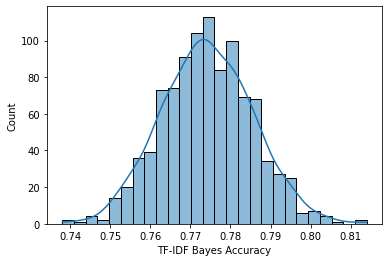

In [28]:
plot_results(accuracies, 'TF-IDF Bayes Accuracy')

### Bayes Model: with both keywords and text as features

Here we run make use of tf-idf in combination with the a bayes.

Important to note is that this model only runs on one feature, i.e. the text.
Thereby the model includes both keywords and text.

We take two approaches:
- Stacking
- Concatination (nth degree)

#### Stacking

In [29]:
clf_nb_stack = MultinomialNB() 

clf_nb_stack.fit(x_train_stack, y_train_stack)

MultinomialNB()

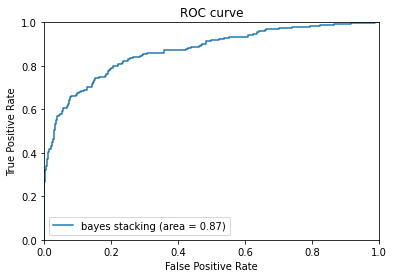

In [30]:
plot_roc(clf_nb_stack, text_val_test_stack, target_val_test_stack, 'bayes stacking')

In [31]:
accuracies = make_norm(text_val_test_stack, target_val_test_stack, clf_nb_stack)

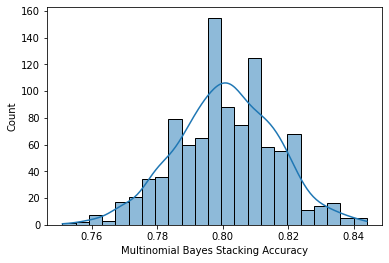

In [32]:
plot_results(accuracies, 'Multinomial Bayes Stacking Accuracy')

#### Concatenation

In [33]:
clf_nb_con = MultinomialNB() 

clf_nb_con.fit(x_train_vect_con, y_train_con)

MultinomialNB()

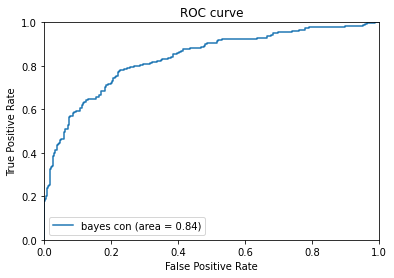

In [34]:
plot_roc(clf_nb_con, x_val_vec_con, target_val_test_con, 'bayes con')

In [35]:
accuracies = make_norm(x_val_vec_con, target_val_test_con, clf_nb_con)

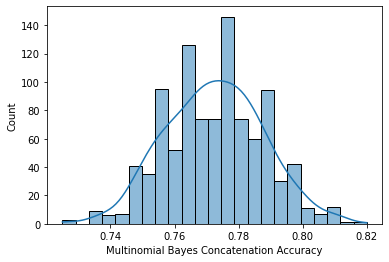

In [36]:
plot_results(accuracies, 'Multinomial Bayes Concatenation Accuracy')